In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
from sklearn.model_selection import cross_val_score
from joblib import dump, load
import xgboost

In [2]:
SOURCE = 'C:/Users/Cactuar/Documents/'

In [3]:
rating_table = pd.read_csv(SOURCE + 'rating_table.csv')
#player_table = pd.read_csv(SOURCE + 'player_table.csv')
match_table = pd.read_csv(SOURCE + 'match_table.csv')

In [4]:
rating_table = rating_table.drop(columns='prev_id')

In [104]:
#rating_table['bf_rating'].describe()

In [105]:
#player_table = player_table.rename(columns={'id':'player_id'})

In [5]:
match_table = match_table[match_table['game']=='LotV']

In [107]:
#match_table.head()

In [6]:
match_table['winning_player'] = np.where(match_table['sca'] < match_table['scb'], 'Player B', 'Player A')

In [7]:
match_table = match_table.drop(['sca', 'scb', 'treated','event','eventobj_id','submitter_id','game','offline'], axis=1)

In [8]:
rta_id = match_table[['id','rta_id']]
rtb_id = match_table[['id','rtb_id']]
rta_id = rta_id.merge(rating_table, left_on='rta_id', right_on='id', how='left')
rtb_id = rtb_id.merge(rating_table, left_on='rtb_id', right_on='id', how='left')
rta_id = rta_id.drop(columns='id_y')
rtb_id = rtb_id.drop(columns='id_y')

In [9]:
merged_ratings = rta_id.merge(rtb_id, on='id_x', how='left')
merged_ratings = merged_ratings.rename(columns={'id_x':'id'})

In [10]:
lotv_merged = match_table.merge(merged_ratings, on='id', how='left')
lotv_merged = lotv_merged.drop(columns=['rta_id_x','rtb_id_x','rta_id_y', 'rtb_id_y', 'period_id_y', 'player_id_x', 'player_id_y','id','period_id','date','pla_id','plb_id'])
lotv_merged = lotv_merged.replace(['Z','T','P','R'],[1,2,3,4])
lotv_merged['rca'] = lotv_merged['rca'].astype(str).astype(int)
lotv_merged['rcb'] = lotv_merged['rcb'].astype(str).astype(int)
lotv_merged = lotv_merged.rename(columns={'rca':'player_a_race', 'rcb':'player_b_race', 'bf_rating_x':'player_a_sRating', 'bf_rating_y':'player_b_sRating', 'rating_x':'player_a_rating','rating_y':'player_b_rating'})
lotv_merged = lotv_merged.dropna()


In [11]:
# baseline majority classifier
lotv_merged['winning_player'].value_counts(normalize=True)

Player A    0.626053
Player B    0.373947
Name: winning_player, dtype: float64

In [12]:
train, test = train_test_split(lotv_merged, stratify=lotv_merged['winning_player'], random_state=42)
#train , val = train_test_split(train, stratify=train['winning_player'], random_state=42)

In [115]:
target = 'winning_player'
X_train = train.drop(columns=target)
#X_val = val.drop(columns=target)
X_test = test.drop(columns=target)
y_test = test[target]
y_train = train[target]
#y_val = val[target]

In [116]:
#dump(X_test, 'X_test.joblib')
#dump(y_test, 'y_test.joblib')



['y_test.joblib']

In [14]:
#feat = X_test.columns.tolist()
#y = lotv_merged[target]
3X = lotv_merged[feat]

In [15]:
#eval_set = [(X_train, y_train), (X_val, y_val)]
#model = XGBClassifier(n_estimators=775, max_depth=10, min_child_weight=7, n_jobs=-1, random_state=42)
#model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=7, missing=None, n_estimators=775, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [79]:
# pickle model
#dump(model, 'alig_predict_model.joblib')

['alig_predict_model.joblib']

In [16]:
#print('Train score:', model.score(X_train, y_train))
#print('Test score:', model.score(X_test, y_test))

Train score: 0.9853485811520944
Test score: 0.8144658809398694


In [52]:
#ypred = model.predict(X_test)
#accuracy_score(y_test, ypred)

0.8144658809398694

In [72]:
#y_pred_proba = model.predict_proba(X_test)[:,1]
#roc_auc_score(y_test, y_pred_proba)

0.8912212671144882

In [56]:
#y_pred = model.predict(X_test)
#print('test accuracy:', accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred))

test accuracy: 0.8144658809398694
              precision    recall  f1-score   support

    Player A       0.84      0.88      0.86     16679
    Player B       0.77      0.71      0.74      9963

   micro avg       0.81      0.81      0.81     26642
   macro avg       0.80      0.79      0.80     26642
weighted avg       0.81      0.81      0.81     26642



In [63]:
#takes forever, try StratifiedKfold, 0.8976
#cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean()

0.897600886846868

In [ ]:
#import sklearn
#sorted(sklearn.metrics.SCORERS.keys())

In [117]:
#results = model.evals_result()
#train_error = results['validation_0']['error']
#val_error = results['validation_1']['error']
#epoch = range(len(train_error))
#plt.plot(epoch, train_error, label='Train')
#plt.plot(epoch, val_error, label='Validation')
#plt.ylim()
#plt.legend();

In [ ]:
#model = XGBClassifier(n_jobs=-1, random_state=42)
#param_dist = {'max_depth': randint(3,12),
#              'learning_rate': uniform(0,1),
#              'n_estimators': randint(200, 1500),
#              'min_child_weight': randint(1,10),
#              'gamma': randint(0,5),
#              'subsample': [0.6, 0.7, 0.8, 0.9, 1],
#              'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
#              }
#
#search = RandomizedSearchCV(model,
#                            param_distributions=param_dist,
#                            n_iter=10,
#                            cv=5,
#                            scoring='accuracy',
#                            verbose=10,
#                            return_train_score=True)
#
#search.fit(X_train, y_train)
#print('Best hyperparameters', search.best_params_)
#print('Best score', search.best_score_)

In [118]:
#y_pred = model.predict(y_test)
#def plot_confusion_matrix(y_true, y_pred):
#  labels = unique_labels(y_true)
#  columns = [f'Predicted {label}' for label in labels]
#  index = [f'Actual {label}' for label in labels]
#  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
#               columns =columns, index = index)
#           
#  return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')
#
#plot_confusion_matrix(y_test, y_pred);

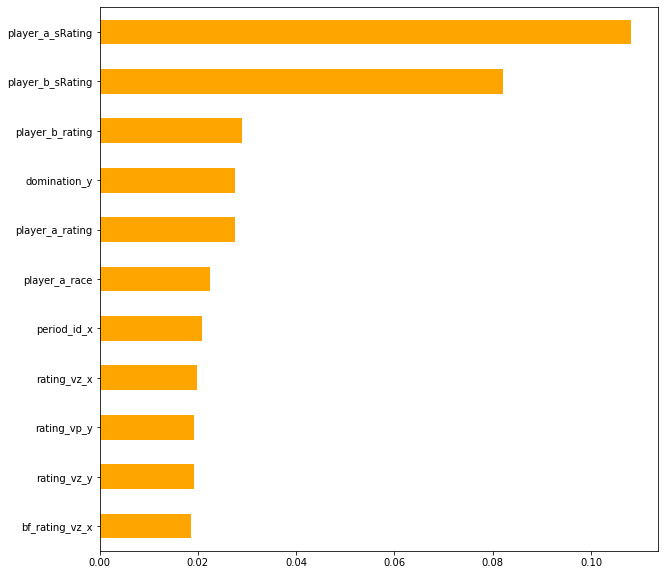

In [52]:
plt.figure(figsize=(10,10))
importances = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
importances = importances[:11].sort_values()
importances.plot.barh(color='orange');

In [53]:
permuter = PermutationImportance(model, cv='prefit',random_state=42)
permuter.fit(X_test, y_test)
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.3049 ± 0.0022,player_b_sRating
0.2819 ± 0.0037,player_a_sRating
0.1313 ± 0.0025,player_a_rating
0.1199 ± 0.0022,player_b_rating
0.0171 ± 0.0011,bf_rating_vz_y
0.0151 ± 0.0030,rating_vz_y
0.0146 ± 0.0020,player_a_race
0.0136 ± 0.0013,bf_rating_vz_x
0.0105 ± 0.0010,bf_rating_vp_y
0.0096 ± 0.0015,player_b_race


In [97]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_proba)
import ipywidgets
from ipywidgets import interact, fixed
def set_threshold(y_true, y_pred_proba, threshold=0.5):
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1
    
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.title('Distribution of predicted probabilities')
    plt.show()
    
    true_positives = (y_pred==y_true) & (y_pred==class_1)
    false_positives = (y_pred!=y_true) & (y_pred==class_1)
    actual_positives = (y_true==class_1)
    actual_negatives = (y_true==class_0)
    true_positive_rate = true_positives.sum() / actual_positives.sum()
    false_positive_rate = false_positives.sum() / actual_negatives.sum()
    print('False Positive Rate', false_positive_rate)
    print('True Positive Rate', true_positive_rate)
    
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.scatter(false_positive_rate, true_positive_rate)
    plt.show()
    
    print('Area under the Receiver Operating Characteristic curve:', 
          roc_auc_score(y_true, y_pred_proba))
    
    plot_confusion_matrix(y_true, y_pred)
    
    
interact(set_threshold, 
         y_true=fixed(y_test), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0,1,0.05));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

In [98]:
print(ipywidgets.__version__)

7.5.0


In [13]:
target = 'winning_player'
features = ['player_a_race', 'player_b_race', 'player_a_sRating', 'player_b_sRating', 'player_a_rating', 'player_b_rating']
X_train = train[features]
X_test = test[features]
y_train = train[target]
y_test = test[target]


In [135]:
app_features = ['winning_player','player_a_race', 'player_b_race', 'player_a_sRating', 'player_b_sRating', 'player_a_rating', 'player_b_rating']
app_df = test[app_features]
app_df =app_df.replace([1,2,3,4],['Zerg','Terran','Protoss','Random'])

In [136]:
app_df.head()

,winning_player,player_a_race,player_b_race,player_a_sRating,player_b_sRating,player_a_rating,player_b_rating
36471,Player A,Terran,Terran,0.058487,-0.068126,0.016941,-0.052186
68890,Player B,Protoss,Zerg,-0.039578,-0.032906,-0.036441,-0.044165
136097,Player A,Zerg,Zerg,0.760528,-0.342310,0.764882,-0.364320
234,Player A,Zerg,Protoss,1.004914,1.040616,0.982632,1.043579
1380,Player A,Protoss,Protoss,0.931994,0.146374,0.936560,0.143425


In [137]:
dump(app_df, 'app_df.joblib')

['app_df.joblib']

In [14]:
new_model = XGBClassifier(n_estimators=775, learning_rate=0.3, max_depth=10, min_child_weight=7,n_jobs=-1, random_state=42, early_stopping_rounds=50)
new_model.fit(X_train, y_train)
#print('Train score:', new_model.score(X_train, y_train))
#print('Test score:', new_model.score(X_test, y_test))
#y_pred_proba = new_model.predict_proba(X_test)[:,1]
#print('ROC_AUC', roc_auc_score(y_test, y_pred_proba))
#y_pred = new_model.predict(X_test)
#print('test accuracy:', accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
              gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=7, missing=None, n_estimators=775, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [124]:
#dump(y_pred_proba, 'y_pred_proba.joblib')

['y_pred_proba.joblib']

In [15]:
X_test.head()

,player_a_race,player_b_race,player_a_sRating,player_b_sRating,player_a_rating,player_b_rating
36471,2,2,0.058487,-0.068126,0.016941,-0.052186
68890,3,1,-0.039578,-0.032906,-0.036441,-0.044165
136097,1,1,0.760528,-0.342310,0.764882,-0.364320
234,1,3,1.004914,1.040616,0.982632,1.043579
1380,3,3,0.931994,0.146374,0.936560,0.143425


In [16]:
# pickle model
#dump(new_model, 'alig_predict_app_model.joblib')

['alig_predict_app_model.joblib']

In [146]:
#def predict(player_a_race, player_b_race, player_a_sRating, player_b_sRating, player_a_rating, player_b_rating):
    #df = pd.DataFrame(
       # columns=['player_a_race', 'player_b_race', 'player_a_sRating', 'player_b_sRating', 'player_a_rating', 'player_b_rating'],
       #data=[[player_a_race, player_b_race, player_a_sRating, player_b_sRating, player_a_rating, player_b_rating]]
 #  )
  #  y_pred = new_model.predict(df)[0]
   # return f'{y_pred} Wins!'

In [147]:
#predict(1, 3, 1, 2,1,1.2)

'Player B Wins!'

In [156]:
#import sklearn
#sklearn.__version__

'0.20.3'

In [157]:
#X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79924 entries, 31729 to 22117
Data columns (total 6 columns):
player_a_race       79924 non-null int32
player_b_race       79924 non-null int32
player_a_sRating    79924 non-null float64
player_b_sRating    79924 non-null float64
player_a_rating     79924 non-null float64
player_b_rating     79924 non-null float64
dtypes: float64(4), int32(2)
memory usage: 3.7 MB


In [162]:
#def predict(player_a_race, player_b_race, player_a_sRating, player_b_sRating, player_a_rating, player_b_rating):
 #   df = pd.DataFrame(
  #      columns=['player_a_race', 'player_b_race', 'player_a_sRating', 'player_b_sRating', 'player_a_rating', 'player_b_rating'],
   #     data=[[player_a_race, player_b_race, player_a_sRating, player_b_sRating, player_a_rating, player_b_rating]]
    #)
    #y_pred = new_model.predict(df)[0]
    #return str(y_pred)+' wins!'

In [163]:
#predict(1,1,2,2,3,3)

'Player A wins!'